In [1]:
import sys
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.ignis.mitigation import CompleteMeasFitter

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error
from qiskit.providers.aer import noise
from qiskit.circuit.library import EfficientSU2
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import warnings
warnings.filterwarnings("ignore")

provider = IBMQ.load_account()


In [2]:
inter_dist = 1.6

In [3]:
driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')

In [4]:
# please be aware that the idx here with respective to original idx
freeze_list = [0]
remove_list = [-3, -2] # negative number denotes the reverse order

In [5]:
#Define our noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates

In [6]:
# Classically solve for the lowest eigenvalue
# This is used just to compare how well you VQE approximation is performing
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    #print('Reference value: {}'.format(ref))
    return ref

# Define your function for computing the qubit operations of LiH
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    
    #print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    #print("# of electrons: {}".format(num_particles))
    #print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)

    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction,energy_shift

In [7]:
def eval_func(opt):
    map_type = 'parity'
    inter_dist = 1.6
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, energy_shift = compute_LiH_qubitOp(map_type, inter_dist)
    init_state = HartreeFock(num_spin_orbitals, num_particles, map_type, qubit_reduction)
    var_form = RYRZ(num_qubits=qubitOp.num_qubits, 
                     depth=3, 
                     entangler_map=[[0,1], [1,2], [1,3]], 
                     entanglement='linear',
                     initial_state=init_state,
                     entanglement_gate='cz', 
                     skip_unentangled_qubits=False)
    backend = Aer.get_backend('qasm_simulator')
    
    quantum_instance = QuantumInstance(backend=backend, 
                                   backend_options={
                                       "zero_threshold":1e-3,
                                       "max_parallel_experiments":0
                                       },
                                   shots=1000,
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30,
                                   basis_gates=basis_gates,
                                   optimization_level=3)

    
    # Choose the classical optimizer
    if opt == 'COBYLA':
        optimizer = COBYLA(maxiter=300, tol=0.0001)
    elif opt == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxiter=300, epsilon=0.0001)
    elif opt == 'SLSQP': 
        optimizer = SLSQP(maxiter=300, tol=0.0001)
    else:
        optimizer = SPSA(max_trials=300)
        
    # Now compare the results of different compositions of your VQE algorithm!
    
    counts=[]
    values = []
    params = []
    deviation = []
    def store_intermediate_result(eval_count, parameters, mean, std):
                counts.append(eval_count)
                values.append(mean)
                params.append(parameters)
                deviation.append(std)

    algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
    algo_result = algo.run(quantum_instance)
    return  algo_result, counts, values, params, deviation

In [8]:
results = []
counts=[]
values = []
params = []
deviation = []
opt = ['COBYLA', 'L_BFGS_B', 'SLSQP', 'SPSA']

for x in opt:
    r_tmp, c_tmp, v_tmp, p_tmp,d_tmp = eval_func(x)
    results.append(r_tmp)
    counts.append(c_tmp)
    values.append(v_tmp)
    params.append(p_tmp)
    deviation.append(d_tmp)
    print('Done: {}'.format(x))

Done: COBYLA
Done: L_BFGS_B
Done: SLSQP
Done: SPSA


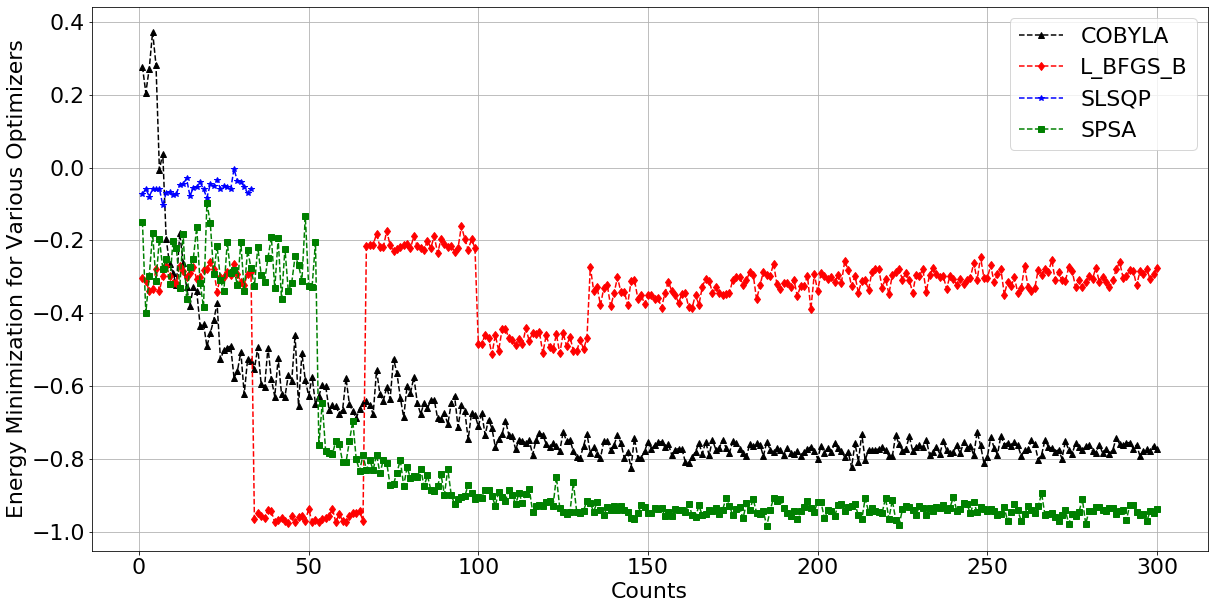

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 22})
plt.plot(counts[0][:300], values[0][:300],'--k^', label="COBYLA")
plt.plot(counts[1][:300], values[1][:300],'--rd', label="L_BFGS_B")
plt.plot(counts[2][:300], values[2][:300],'--b*', label="SLSQP")
plt.plot(counts[3][:300], values[3][:300],'--gs', label="SPSA")
# plt.plot(distances, vqe_energies+energy_shift_plus-energy_shift_minus,'--g^', label="VQE Energy")
plt.xlabel('Counts')
plt.ylabel('Energy Minimization for Various Optimizers')
plt.grid( which='both', axis='both')
plt.legend()
plt.savefig('Convergence.png')

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright